In [1]:
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import matplotlib.colors as mcolors
from scipy.linalg import cholesky, solve_triangular
from scipy.stats import norm
import pandas as pd
from IPython.display import display
rng = np.random.default_rng(832003)

In [2]:
image_size = 50 # image size in pixels
fwhm = 5.4

cmap = plt.cm.viridis.copy()  # Copy the viridis colormap
# Create a colormap where 0 is forced to white
cmap.set_bad(color='white')  # For masked values
cmap.set_under(color='white')  # For explicitly set zero values

In [ ]:
def find_covariance_matrix(image_size,sigma,rms_noise=0.15):
    """
    - Inputs:
        - image_size: data dimensionality
        - sigma: standard deviation of the target distribution.
    - Outputs:
        - Correlation matrix: the corrlation matrix as specified in the algorithm in the markdown cells above.
    """
    x, y = np.meshgrid(np.arange(image_size), np.arange(image_size), indexing="ij")
    pixel_coords = np.stack((x.ravel(), y.ravel()), axis=1)
    i, j = pixel_coords[:, 0], pixel_coords[:, 1] 

    di = i[:, None] - i[None, :] # Difference in x for all coordinates
    dj = j[:, None] - j[None, :] # Difference in y for all coordinats
    d = 1.8*np.sqrt(di**2 + dj**2) # d[x,x'] difference in euclidean distance between the two pixels in the (RA,\delta) ~ Euclidean R^{22500 \otimes 22500}

    C= (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-d**2 / (2 * sigma**2)) # Just the N(0,sigma^2)

    # Set the diagonal elements to 1
    np.fill_diagonal(C, 1)
    # Normalize the covariance matrix
    return C* rms_noise**2

In [4]:
cov,distances = find_covariance_matrix(image_size, fwhm)

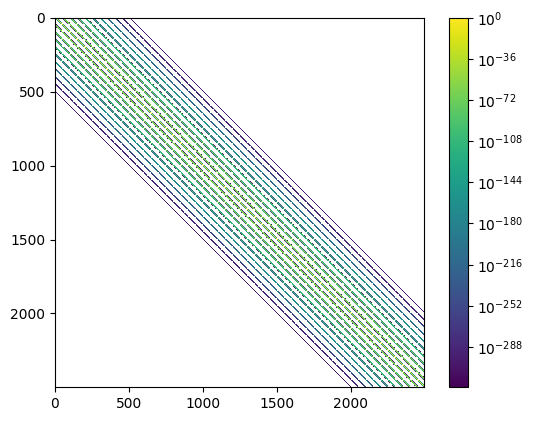

In [15]:
plt.imshow(cov, cmap=cmap, interpolation='nearest',norm=LogNorm())
plt.colorbar()
plt.show()

In [6]:
def block_diagonal_mvg_NLL(cov,x,mu,n,batch_size=1):
    """
    Calculates the multivariate gaussian neg-log-likelihood for a block diagonal approximation of the matrix.
    inputs:
        - cov: the covariance matrix
        - x: the data flattened
        - mu: the mean flattened
        - n: the block size
    returns:
        - the negative log-likelihood
    """
    num_blocks = len(x) // n
    remainder_size = len(x) % n

    B = cov[:n,:n] # Get the block
    L = cholesky(B, lower=True) # Cholesky decomposition
    logdet = 2*np.sum(np.log(np.diag(L))) # Log determinant

    z = x-mu
    malahanobis = 0
    for i in range(num_blocks):
        zi = z[i*n:(i+1)*n]
        yi = solve_triangular(L,zi,lower=True)
        malahanobis += np.dot(yi,yi)
    if remainder_size > 0:
        B_rem = cov[:remainder_size,:remainder_size] # Take the same assumption for the remainder size
        L_rem = cholesky(B_rem, lower=True)
        zi = z[num_blocks*n:]
        yi = solve_triangular(L_rem,zi,lower=True)
        malahanobis += np.dot(yi,yi)
        logdet += 2*np.sum(np.log(np.diag(L_rem)))

    return 0.5*(logdet + malahanobis + len(x)*batch_size*np.log(2*np.pi))

def negative_log_likelihood_cholesky(x, mu, cov):
    """
    Calculates the multivariate gaussian neg-log-likelihood for the matrix.
    inputs:
        - cov: the covariance matrix
        - x: the data flattened
        - mu: the mean flattened
        - n: the block size
    returns:
        - the negative log-likelihood
    """
    L = cholesky(cov, lower=True)
    y = solve_triangular(L, x - mu, lower=True)
    
    quad_term = np.dot(y, y)
    log_det = 2 * np.sum(np.log(np.diag(L)))
    

    n = len(x)
    nll = 0.5 * (log_det + quad_term + n * np.log(2 * np.pi))
    return nll


x = rng.random(image_size**2)
mu = rng.random(image_size**2)

In [7]:
NLL_tradiational = negative_log_likelihood_cholesky(x, mu, cov)
NLL_block = block_diagonal_mvg_NLL(cov,x,mu,12)

In [8]:
NLL_block/NLL_tradiational

1.0007027738240348

In [9]:
import torch
def block_diagonal_mvg_NLL(cov, x, mu, n, batch_size=1):
    # x is of shape (batch_size, D) where D = total pixels
    # cov is the full covariance matrix from which we take the top-left block for every block.
    batch_size, D = x.shape
    num_blocks = D // n
    remainder_size = D % n
    z = x - mu  # shape: (batch_size, D)

    # Process main blocks using the top-left block slice from cov
    if num_blocks > 0:
        # Always use the same top-left block
        cov_main = cov[:n, :n]  # shape: (n, n)
        L_main = torch.linalg.cholesky(cov_main)  # shape: (n, n)
        # Expand L_main to apply to every block in every batch:
        # New shape: (batch_size, num_blocks, n, n)
        L_main_batch = L_main.unsqueeze(0).unsqueeze(0).expand(batch_size, num_blocks, n, n)
        # Extract the main blocks from z: shape (batch_size, num_blocks, n)
        z_main = z[:, :num_blocks * n].reshape(batch_size, num_blocks, n)
        # Solve for y in L_main * y = z_main (batched triangular solve)
        y_main = torch.linalg.solve_triangular(L_main_batch, z_main.unsqueeze(-1), upper=False).squeeze(-1)
        # Sum the squared solutions
        mahalanobis_main = (y_main ** 2).sum()
        # The log determinant from the top-left block, repeated for each block
        logdet_main = num_blocks * (2 * torch.sum(torch.log(torch.diag(L_main))))
    else:
        mahalanobis_main = 0
        logdet_main = 0

    # Process the remainder block (if it exists) using its corresponding top-left slice
    if remainder_size > 0:
        cov_rem = cov[:remainder_size, :remainder_size]
        L_rem = torch.linalg.cholesky(cov_rem)
        z_rem = z[:, num_blocks * n:]
        # Expand L_rem for the batch dimension: (batch_size, remainder_size, remainder_size)
        L_rem_batch = L_rem.unsqueeze(0).expand(batch_size, remainder_size, remainder_size)
        y_rem = torch.linalg.solve_triangular(L_rem_batch, z_rem.unsqueeze(-1), upper=False).squeeze(-1)
        mahalanobis_rem = (y_rem ** 2).sum()
        logdet_rem = 2 * torch.sum(torch.log(torch.diag(L_rem)))
    else:
        mahalanobis_rem = 0
        logdet_rem = 0

    total_logdet = logdet_main + logdet_rem
    total_mahalanobis = mahalanobis_main + mahalanobis_rem

    # Final negative log-likelihood calculation
    nll = 0.5 * (total_logdet + total_mahalanobis + D * batch_size * torch.log(torch.tensor(2) * torch.pi))
    return nll

In [10]:
# Define parameters
image_size = 50
D = image_size ** 2
batch_size = 1  # or any batch size you want

# Generate synthetic data using torch.rand
x = torch.rand(batch_size, D)
mu = torch.rand(batch_size, D)

In [11]:
NLL_block_torch = block_diagonal_mvg_NLL(torch.tensor(cov),x,mu,12).item()

In [16]:
NLL_block/NLL_tradiational

1.0007027738240348

In [ ]:
np.linalg.det(find_covariance_matrix(150, fwhm))